# Metrics

This notebook contains training metrics history and classification
metrics computed on the predictions by - mhcflurry (benchmark) - mhcpred

In [25]:
from pathlib import Path
import pickle

from mhcpred.config import settings
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models_path = Path(settings.models_path)
output_path = Path(settings.output_path)

**Information on the training history**

I prefer to use tensorboard, but it is not implemented in the mhcflurry
package. The information is quite scarce, but when you execute the code,
you have the loss for each step and not only for the whole epoch. Of
course, it is a very basic version of logging and should be improved.

In [26]:
with open(str(models_path / "model.pickle"), "rb") as f:
    model = pickle.load(f)

In [27]:
model.fit_info

[{'learning_rate': 0.0010000000474974513,
  'loss': [0.09700655937194824, 0.06465369462966919],
  'val_loss': [0.06880103051662445, 0.05075661838054657],
  'time': 524.7155420780182,
  'num_points': 6628048}]

**Binary classification metrics**

We compute the usual binary classification metrics on the unbalanced
test dataset: accuracy, balanced accuracy, confusion matrix and
classification report by scikit-learn.

We report the unbalanced accuracy because the dataset is very unbalanced
so the accuracy only is not a good measure of accuracy (the model can
predict always False and it works quite well).

**mhcflurry metrics**

In [28]:
mhcflurry_rank_percentile_threshold = 2  # rank threshold for positive hits
# It comes from the mhcflurry article.

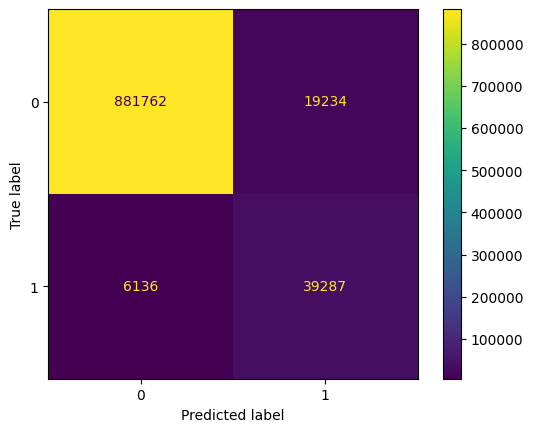

In [29]:
df = pd.read_csv(str(output_path / "mhcflurry_predictions.csv"))
y_pred = df.prediction_percentile.values <= mhcflurry_rank_percentile_threshold
y_true = df.hit.values
acc = accuracy_score(y_true=y_true, y_pred=y_pred)
confusion_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
balanced_acc = balanced_accuracy_score(y_true=y_true, y_pred=y_pred)
class_report = classification_report(y_true=y_true, y_pred=y_pred, output_dict=False)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
disp.plot()
plt.show()

In [30]:
print(class_report)

              precision    recall  f1-score   support

       False       0.99      0.98      0.99    900996
        True       0.67      0.86      0.76     45423

    accuracy                           0.97    946419
   macro avg       0.83      0.92      0.87    946419
weighted avg       0.98      0.97      0.97    946419


In [31]:
acc, balanced_acc

(0.9731936911663861, 0.9217833819652606)

The metrics are quite good. We note that we do not have a good precision
on the True class (0.67), the model has a tendency to predict True too
often, so we have too many False Positives. We see it on the confusion
matrix, 19234 False Positives.

**mhcpred metrics**

In [32]:
mhcpred_proba_threshold = 0.5  # by default, but we try to tune it later

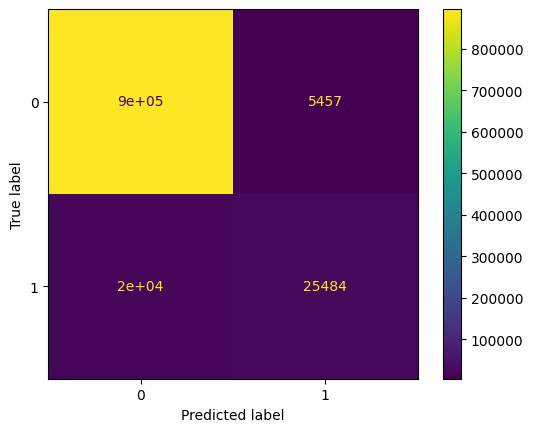

In [33]:
df = pd.read_csv(str(output_path / "mhcpred_predictions.csv"))
y_true = df.hit.values
y_pred = df.predictions.values >= mhcpred_proba_threshold
acc = accuracy_score(y_true=df.hit.values, y_pred=y_pred)
confusion_mat = confusion_matrix(y_true=df.hit.values, y_pred=y_pred)
balanced_acc = balanced_accuracy_score(y_true=df.hit.values, y_pred=y_pred)

class_report = classification_report(y_true=y_true, y_pred=y_pred, output_dict=False)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
disp.plot()
plt.show()

In [34]:
acc, balanced_acc

(0.9731657332258088, 0.7775326900487307)

In [35]:
print(class_report)

              precision    recall  f1-score   support

       False       0.98      0.99      0.99    900725
        True       0.82      0.56      0.67     45416

    accuracy                           0.97    946141
   macro avg       0.90      0.78      0.83    946141
weighted avg       0.97      0.97      0.97    946141


mhcpred has worse performances compared to mhcflurry, see the balanced
accuracy. On the True class, in that case, the recall is not good
(0.56), the model has a tendency to predict False too often, on the
confusion matrix we have 20000 True Negatives. It indicates that if we
lower the threshold, we may improve the model.

**Threshold tuning**

We plot the precision recall curve to try to identify a better
threshold.

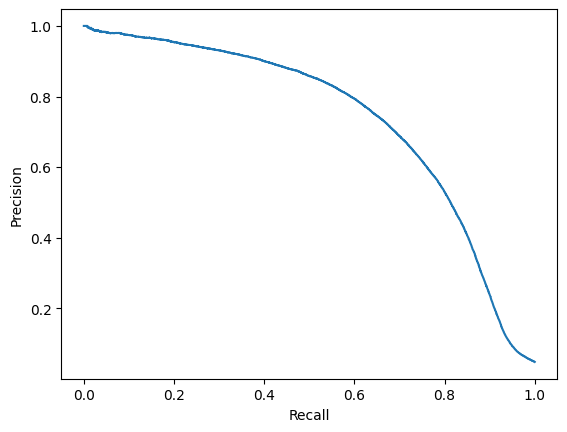

In [36]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(y_true=y_true, probas_pred=df.predictions.values)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

plt.show()

In [37]:
precision_recall_thresholds = pd.DataFrame({
    "precision": precision[:-1],
    "recall": recall[:-1],
    "thresholds": thresholds,
})

In [38]:
precision_recall_thresholds

889318 rows × 3 columns

A threshold of approx. 0.2 seems to be a good compromise for
precision/recall.

In [39]:
mhcpred_proba_threshold = 0.2

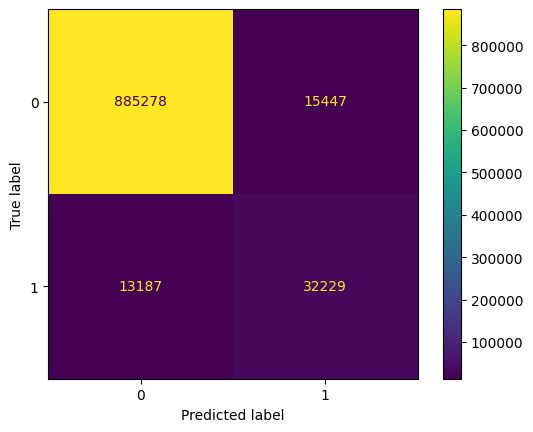

In [40]:
df = pd.read_csv(str(output_path / "mhcpred_predictions.csv"))
y_true = df.hit.values
y_pred = df.predictions.values >= mhcpred_proba_threshold
acc = accuracy_score(y_true=df.hit.values, y_pred=y_pred)
confusion_mat = confusion_matrix(y_true=df.hit.values, y_pred=y_pred)
balanced_acc = balanced_accuracy_score(y_true=df.hit.values, y_pred=y_pred)

class_report = classification_report(y_true=y_true, y_pred=y_pred, output_dict=False)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
disp.plot()
plt.show()

In [41]:
acc, balanced_acc

(0.9697360118629252, 0.8462451280426622)

In [42]:
print(class_report)

              precision    recall  f1-score   support

       False       0.99      0.98      0.98    900725
        True       0.68      0.71      0.69     45416

    accuracy                           0.97    946141
   macro avg       0.83      0.85      0.84    946141
weighted avg       0.97      0.97      0.97    946141


We see that we have improved the balanced accuracy. We have a
deterioration of the precision but a better recall.